In [29]:
#import libraries
import os
from pandas import read_csv
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

%matplotlib inline

import pandas_profiling


from scipy.stats import skew, norm
from scipy import stats
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, RobustScaler
from sklearn import linear_model
from sklearn.linear_model import ElasticNetCV, ElasticNet, LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, classification_report, accuracy_score
from math import sqrt



from lightgbm import LGBMRegressor
import lightgbm as lgb

In [3]:
#import data
current_path = os.getcwd()
current_path = os.path.dirname(current_path)
print(current_path)
#C:\Users\jonat\Desktop\capstone\nfl2\nfl_capstone\data_mart
dataset = current_path + '//data_mart//reporting_wr.csv'
print(dataset)
dataset = pd.read_csv(dataset, index_col = 0)
dataset.head()

#https://stackoverflow.com/questions/9856683/using-pythons-os-path-how-do-i-go-up-one-director

C:\Users\jonat\Desktop\capstone\nfl2\nfl_capstone
C:\Users\jonat\Desktop\capstone\nfl2\nfl_capstone//data_mart//reporting_wr.csv


,espn_id,full_name,first_name,last_name,position,position_group,section,college,draft_year,selection_number,...,receiving_rec_yards_zscore,receiving_receptions_zscore,receiving_rush_att_zscore,receiving_rush_td_zscore,receiving_rush_yds_zscore,receiving_scrim_plays_zscore,receiving_scrim_tds_zscore,receiving_scrim_yds_zscore,receiving_seasons_zscore,max_madden_zscore
fms_id,,,,,,,,,,,,,,,,,,,,,
2,4047646.0,A.J. Brown,A.J.,Brown,WR,WR,O,Ole Miss,2019,NaN,...,1.020082,0.745111,-0.597165,-0.440830,-0.564573,0.523967,0.277925,0.911099,-0.273056,-0.145738
216,3914328.0,Andy Isabella,Andy,Isabella,WR,WR,O,UMass,2019,NaN,...,1.596537,1.364694,1.560318,1.048808,2.030272,1.613414,1.681258,1.821476,0.634520,-0.145738
248,4049301.0,Anthony Johnson,Anthony,Johnson,WR,WR,O,Buffalo,2019,NaN,...,0.363859,-0.080999,-0.381417,-0.440830,-0.602509,-0.166902,0.925617,0.270539,-1.180632,-0.896762
275,4043161.0,Antoine Wesley,Antoine,Wesley,WR,WR,O,Texas Tech,2019,NaN,...,-0.508269,-0.597318,-0.543228,-0.440830,-0.579748,-0.671767,-0.801563,-0.570839,-0.273056,NaN
434,3917067.0,Bisi Johnson,Bisi,Johnson,WR,WR,O,Colorado State,2019,NaN,...,-0.006263,-0.199015,-0.543228,-0.440830,-0.465939,-0.313047,-0.585665,-0.069308,0.634520,NaN


In [ ]:

dataset['football_spending']=dataset['coaches_salaries']=dataset['ticket_sales']=np.nan
dataset['poverty_pct']=dataset['med_income']=dataset['ann_rain_inch']=dataset['ann_snow_inch']=dataset['min_jan']=dataset['min_feb']=dataset['min_mar']=dataset['min_apr']=dataset['min_may']=dataset['min_jun']=dataset['min_jul']=dataset['min_aug']=dataset['min_sep']=dataset['min_oct']=dataset['min_nov']=dataset['min_dec']=dataset['max_jan']=dataset['max_feb']=dataset['max_mar']=dataset['max_apr']=dataset['max_may']=dataset['max_jun']=dataset['max_jul']=dataset['max_aug']=dataset['max_sep']=dataset['max_oct']=dataset['max_nov']=dataset['max_dec']=np.nan
for i in range(dataset.shape[0]):
  lookup_val = dataset['fms_id'][i]
  college_val = player_dim.loc[player_dim['fms_id'] == lookup_val]['fms_college_id'].values[0]
  dataset.at[i,'football_spending'] = college_df.loc[college_df['fms_college_id'] == college_val]['football_spending'].values[0]
  dataset.at[i,'coaches_salaries'] = college_df.loc[college_df['fms_college_id'] == college_val]['coaches_salaries'].values[0]
  dataset.at[i,'ticket_sales'] = college_df.loc[college_df['fms_college_id'] == college_val]['ticket_sales'].values[0]
  city_val = college_dim.loc[college_dim['fms_college_id'] == college_val]['fms_city_id'].values[0]
  dataset.at[i,'poverty_pct'] = city_df.loc[city_df['fms_city_id'] == city_val]['poverty_pct'].values[0]
  tmp = city_df.loc[city_df['fms_city_id'] == city_val]['med_income'].values[0]
  if type(tmp) == str:
    tmp = tmp.replace('$','').replace(',','')
  dataset.at[i,'med_income'] = tmp
  dataset.at[i,'ann_rain_inch'] = city_df.loc[city_df['fms_city_id'] == city_val]['ann_rain_inch'].values[0]
  dataset.at[i,'ann_snow_inch'] = city_df.loc[city_df['fms_city_id'] == city_val]['ann_snow_inch'].values[0]
  dataset.at[i,'min_jan'] = city_df.loc[city_df['fms_city_id'] == city_val]['min_jan'].values[0]
  dataset.at[i,'min_feb'] = city_df.loc[city_df['fms_city_id'] == city_val]['min_feb'].values[0]
  dataset.at[i,'min_mar'] = city_df.loc[city_df['fms_city_id'] == city_val]['min_mar'].values[0]
  dataset.at[i,'min_apr'] = city_df.loc[city_df['fms_city_id'] == city_val]['min_apr'].values[0]
  dataset.at[i,'min_may'] = city_df.loc[city_df['fms_city_id'] == city_val]['min_may'].values[0]
  dataset.at[i,'min_jun'] = city_df.loc[city_df['fms_city_id'] == city_val]['min_jun'].values[0]
  dataset.at[i,'min_jul'] = city_df.loc[city_df['fms_city_id'] == city_val]['min_jul'].values[0]
  dataset.at[i,'min_aug'] = city_df.loc[city_df['fms_city_id'] == city_val]['min_aug'].values[0]
  dataset.at[i,'min_sep'] = city_df.loc[city_df['fms_city_id'] == city_val]['min_sep'].values[0]
  dataset.at[i,'min_oct'] = city_df.loc[city_df['fms_city_id'] == city_val]['min_oct'].values[0]
  dataset.at[i,'min_nov'] = city_df.loc[city_df['fms_city_id'] == city_val]['min_nov'].values[0]
  dataset.at[i,'min_dec'] = city_df.loc[city_df['fms_city_id'] == city_val]['min_dec'].values[0]
  dataset.at[i,'max_jan'] = city_df.loc[city_df['fms_city_id'] == city_val]['max_jan'].values[0]
  dataset.at[i,'max_feb'] = city_df.loc[city_df['fms_city_id'] == city_val]['max_feb'].values[0]
  dataset.at[i,'max_mar'] = city_df.loc[city_df['fms_city_id'] == city_val]['max_mar'].values[0]
  dataset.at[i,'max_apr'] = city_df.loc[city_df['fms_city_id'] == city_val]['max_apr'].values[0]
  dataset.at[i,'max_may'] = city_df.loc[city_df['fms_city_id'] == city_val]['max_may'].values[0]
  dataset.at[i,'max_jun'] = city_df.loc[city_df['fms_city_id'] == city_val]['max_jun'].values[0]
  dataset.at[i,'max_jul'] = city_df.loc[city_df['fms_city_id'] == city_val]['max_jul'].values[0]
  dataset.at[i,'max_aug'] = city_df.loc[city_df['fms_city_id'] == city_val]['max_aug'].values[0]
  dataset.at[i,'max_sep'] = city_df.loc[city_df['fms_city_id'] == city_val]['max_sep'].values[0]
  dataset.at[i,'max_oct'] = city_df.loc[city_df['fms_city_id'] == city_val]['max_oct'].values[0]
  dataset.at[i,'max_nov'] = city_df.loc[city_df['fms_city_id'] == city_val]['max_nov'].values[0]
  dataset.at[i,'max_dec'] = city_df.loc[city_df['fms_city_id'] == city_val]['max_dec'].values[0]

In [4]:
#determine which columns have None values
none_columns = []
for x in dataset.columns:
    if dataset[x].isnull().values.any() == True:
        none_columns.append(x)
print(none_columns)

['espn_id', 'selection_number', 'position_rank', 'position_group_rank', 'section_rank', 'drafting_team', 'home_city', 'home_state', 'home_country', 'forty', 'vertical', 'bench', 'broad', 'threecone', 'shuttle', 'max_madden', 'forty_zscore', 'vertical_zscore', 'bench_zscore', 'broad_zscore', 'threecone_zscore', 'shuttle_zscore', 'max_madden_zscore']


In [5]:
def z_score_rescale(data_mean, data_std, z_score):
    X = (z_score* data_std) + data_mean
    return X

In [6]:
dataset['max_madden'].describe()

count    466.000000
mean      73.358369
std        9.330624
min       52.000000
25%       66.000000
50%       72.000000
75%       79.000000
max       99.000000
Name: max_madden, dtype: float64

In [7]:
#Deal with None Values
none_dict = {'espn_id': 0,    
    'selection_number': 400,
    'position_rank': 400,
    'position_group_rank': 400,
    'section_rank': 400,
    'drafting_team': 'No Team',
    'home_city': 'No City',
    'home_state': 'No State',
    'home_country': 'USA',
    'forty': dataset['forty'].mean(),
    'vertical': dataset['vertical'].mean(), 
    'bench': dataset['bench'].mean(), 
    'broad': dataset['broad'].mean(),
    'threecone': dataset['threecone'].mean(),
    'shuttle': dataset['shuttle'].mean(),
    'football_spending': dataset['shuttle'].mean(), 
    'coaches_salaries': dataset['shuttle'].mean(), 
    'ticket_sales': dataset['shuttle'].mean(), 
    'poverty_pct': dataset['shuttle'].mean(), 
    'med_income': dataset['shuttle'].mean(),
    'max_madden': dataset['max_madden'].min() - 10,
    'forty_zscore': dataset['forty_zscore'].mean(), 
    'vertical_zscore': dataset['vertical_zscore'].mean(), 
    'bench_zscore': dataset['bench_zscore'].mean(), 
    'broad_zscore': dataset['broad_zscore'].mean(), 
    'threecone_zscore': dataset['threecone_zscore'].mean(), 
    'shuttle_zscore': dataset['shuttle_zscore'].mean(), 
    'max_madden_zscore': dataset['max_madden_zscore'].min() - 0.1}
    #'football_spending_zscore': dataset['football_spending_zscore'].min(), 
    #'coaches_salaries_zscore':  dataset['coaches_salaries_zscore'].min(), 
    #'ticket_sales_zscore':  dataset['ticket_sales_zscore'].min()}

print(none_dict)

for none_col in none_columns:
    dataset[none_col] = dataset[none_col].fillna(none_dict[none_col])
   

#https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html

{'espn_id': 0, 'selection_number': 400, 'position_rank': 400, 'position_group_rank': 400, 'section_rank': 400, 'drafting_team': 'No Team', 'home_city': 'No City', 'home_state': 'No State', 'home_country': 'USA', 'forty': 0, 'vertical': 0, 'bench': 0, 'broad': 0, 'threecone': 0, 'shuttle': 0, 'max_madden': 42.0, 'forty_zscore': -3.7739118621057414e-15, 'vertical_zscore': 1.0559149014391581e-15, 'bench_zscore': -1.8079967831045805e-16, 'broad_zscore': -9.376001123702435e-16, 'threecone_zscore': 3.622648987438306e-15, 'shuttle_zscore': -1.354387015481417e-15, 'max_madden_zscore': -2.3915212250992455}


In [8]:
dataset.head()

,espn_id,full_name,first_name,last_name,position,position_group,section,college,draft_year,selection_number,...,receiving_rec_yards_zscore,receiving_receptions_zscore,receiving_rush_att_zscore,receiving_rush_td_zscore,receiving_rush_yds_zscore,receiving_scrim_plays_zscore,receiving_scrim_tds_zscore,receiving_scrim_yds_zscore,receiving_seasons_zscore,max_madden_zscore
fms_id,,,,,,,,,,,,,,,,,,,,,
2,4047646.0,A.J. Brown,A.J.,Brown,WR,WR,O,Ole Miss,2019,400.0,...,1.020082,0.745111,-0.597165,-0.440830,-0.564573,0.523967,0.277925,0.911099,-0.273056,-0.145738
216,3914328.0,Andy Isabella,Andy,Isabella,WR,WR,O,UMass,2019,400.0,...,1.596537,1.364694,1.560318,1.048808,2.030272,1.613414,1.681258,1.821476,0.634520,-0.145738
248,4049301.0,Anthony Johnson,Anthony,Johnson,WR,WR,O,Buffalo,2019,400.0,...,0.363859,-0.080999,-0.381417,-0.440830,-0.602509,-0.166902,0.925617,0.270539,-1.180632,-0.896762
275,4043161.0,Antoine Wesley,Antoine,Wesley,WR,WR,O,Texas Tech,2019,400.0,...,-0.508269,-0.597318,-0.543228,-0.440830,-0.579748,-0.671767,-0.801563,-0.570839,-0.273056,-2.391521
434,3917067.0,Bisi Johnson,Bisi,Johnson,WR,WR,O,Colorado State,2019,400.0,...,-0.006263,-0.199015,-0.543228,-0.440830,-0.465939,-0.313047,-0.585665,-0.069308,0.634520,-2.391521


In [9]:
#create categories for Madden Scores
def f(row):
    if row['max_madden'] >= 90 : val = 90
    elif row['max_madden'] < 90 and row['max_madden'] >= 80 : val = 80
    elif row['max_madden'] < 80 and row['max_madden'] >= 70 : val = 70  
    elif row['max_madden'] < 70 and row['max_madden'] >= 60 : val = 60
    elif row['max_madden'] < 60 and row['max_madden'] >= 50 : val = 50
    elif row['max_madden'] < 50 and row['max_madden'] >= 40 : val = 40
    else: val = 40
    return val
dataset['madden_cat'] = dataset.apply(f, axis=1)



In [10]:

#determine % of no madden scores wanted
no_madden_percentage = .20

no_madden_df = dataset.loc[dataset['madden_cat'] == 40]
madden_df = dataset.loc[dataset['madden_cat'] != 40]

print(no_madden_df.shape)
print(madden_df.shape)

current_no_madden_percentage = no_madden_df.shape[0] / dataset.shape[0] - no_madden_percentage
print(current_no_madden_percentage)
if current_no_madden_percentage > 0:
    remove_num = int(current_no_madden_percentage * dataset.shape[0])
    random_no_madden = np.random.choice(no_madden_df.index, remove_num)
    no_madden_df = no_madden_df.drop(random_no_madden)

print(no_madden_df.shape[0] / (no_madden_df.shape[0] + madden_df.shape[0]))
dataset = madden_df.append(no_madden_df)
dataset.head()
dataset = shuffle(dataset)
dataset.head()

#https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset

(345, 60)
(466, 60)
0.22540073982737358
0.2971342383107089


,espn_id,full_name,first_name,last_name,position,position_group,section,college,draft_year,selection_number,...,receiving_receptions_zscore,receiving_rush_att_zscore,receiving_rush_td_zscore,receiving_rush_yds_zscore,receiving_scrim_plays_zscore,receiving_scrim_tds_zscore,receiving_scrim_yds_zscore,receiving_seasons_zscore,max_madden_zscore,madden_cat
fms_id,,,,,,,,,,,,,,,,,,,,,
1251,4259423.0,Darius Johnson,Darius,Johnson,WR,WR,O,SMU,2013,300.0,...,1.379446,-0.543228,-0.440830,-0.556986,1.108549,0.385873,0.778250,0.634520,-0.896762,60
1176,0.0,Damian Copeland,Damian,Copeland,WR,WR,O,Louisville,2014,300.0,...,-0.331783,-0.381417,-0.440830,-0.382479,-0.392763,-1.017460,-0.570839,-0.273056,-2.391521,40
3863,0.0,Patrick Turner,Patrick,Turner,WR,WR,O,USC,2009,87.0,...,-0.007240,-0.597165,-0.440830,-0.564573,-0.153616,0.062027,-0.357663,0.634520,-0.896762,60
2757,0.0,Julio Jones,Julio,Jones,WR,WR,O,Alabama,2011,6.0,...,0.597591,-0.057794,1.048808,0.490057,0.523967,0.062027,0.713370,-0.273056,2.643780,90
1551,0.0,Devard Darling,Devard,Darling,WR,WR,O,Washington State,2004,82.0,...,-0.479303,-0.327480,0.303989,-0.223146,-0.512336,0.385873,-0.399886,-0.273056,-2.391521,40


In [11]:
dataset.columns

Index(['espn_id', 'full_name', 'first_name', 'last_name', 'position',
       'position_group', 'section', 'college', 'draft_year',
       'selection_number', 'position_rank', 'position_group_rank',
       'section_rank', 'drafting_team', 'home_city', 'home_state',
       'home_country', 'college_weight_pounds', 'college_height_inches',
       'hw_ratio', 'forty', 'vertical', 'bench', 'broad', 'threecone',
       'shuttle', 'receiving_games', 'receiving_rec_td', 'receiving_rec_yards',
       'receiving_receptions', 'receiving_rush_att', 'receiving_rush_td',
       'receiving_rush_yds', 'receiving_scrim_plays', 'receiving_scrim_tds',
       'receiving_scrim_yds', 'receiving_seasons', 'max_madden',
       'college_weight_pounds_zscore', 'college_height_inches_zscore',
       'hw_ratio_zscore', 'forty_zscore', 'vertical_zscore', 'bench_zscore',
       'broad_zscore', 'threecone_zscore', 'shuttle_zscore',
       'receiving_games_zscore', 'receiving_rec_td_zscore',
       'receiving_rec_yard

In [12]:

#Total Features
"""['espn_id', 'full_name', 'first_name', 'last_name', 'position',
       'position_group', 'section', 'college', 'draft_year',
       'selection_number', 'position_rank', 'position_group_rank',
       'section_rank', 'drafting_team', 'home_city', 'home_state',
       'home_country', 'college_weight_pounds', 'college_height_inches',
       'hw_ratio', 'forty', 'vertical', 'bench', 'broad', 'threecone',
       'shuttle', 'receiving_games', 'receiving_rec_td', 'receiving_rec_yards',
       'receiving_receptions', 'receiving_rush_att', 'receiving_rush_td',
       'receiving_rush_yds', 'receiving_scrim_plays', 'receiving_scrim_tds',
       'receiving_scrim_yds', 'receiving_seasons', 'max_madden',
       'college_weight_pounds_zscore', 'college_height_inches_zscore',
       'hw_ratio_zscore', 'forty_zscore', 'vertical_zscore', 'bench_zscore',
       'broad_zscore', 'threecone_zscore', 'shuttle_zscore',
       'receiving_games_zscore', 'receiving_rec_td_zscore',
       'receiving_rec_yards_zscore', 'receiving_receptions_zscore',
       'receiving_rush_att_zscore', 'receiving_rush_td_zscore',
       'receiving_rush_yds_zscore', 'receiving_scrim_plays_zscore',
       'receiving_scrim_tds_zscore', 'receiving_scrim_yds_zscore',
       'receiving_seasons_zscore', 'max_madden_zscore', 'madden_cat']"""

# 'college_weight_pounds', 'college_height_inches'


features = ['college_weight_pounds', 'college_height_inches',
       'forty', 'vertical', 'bench', 'broad', 'threecone',
       'shuttle', 'receiving_games', 'receiving_rec_td', 'receiving_rec_yards',
       'receiving_receptions', 'receiving_rush_att', 'receiving_rush_td',
       'receiving_rush_yds', 'receiving_scrim_plays', 'receiving_scrim_tds',
       'receiving_scrim_yds', 'receiving_seasons']

z_features = ['hw_ratio_zscore', 'forty_zscore', 'vertical_zscore', 'bench_zscore',
       'broad_zscore', 'threecone_zscore', 'shuttle_zscore',
       'receiving_games_zscore', 'receiving_rec_td_zscore',
       'receiving_rec_yards_zscore', 'receiving_receptions_zscore',
       'receiving_rush_att_zscore', 'receiving_rush_td_zscore',
       'receiving_rush_yds_zscore', 'receiving_scrim_plays_zscore',
       'receiving_scrim_tds_zscore', 'receiving_scrim_yds_zscore',
       'receiving_seasons_zscore']

z_features_per_game = ['hw_ratio_zscore', 'forty_zscore', 'vertical_zscore', 'bench_zscore',
       'broad_zscore', 'threecone_zscore', 'shuttle_zscore',
       'rushing_rec_td_pg_zscore', 'rushing_rec_yards_pg_zscore',
       'rushing_receptions_pg_zscore', 'rushing_rush_att_pg_zscore',
       'rushing_rush_td_pg_zscore', 'rushing_rush_yds_pg_zscore',
       'rushing_scrim_plays_pg_zscore', 'rushing_scrim_tds_pg_zscore',
       'rushing_scrim_yds_pg_zscore', 'football_spending_zscore',
       'coaches_salaries_zscore', 'ticket_sales_zscore']





limit_features = ['rushing_rush_yds_zscore', 'rushing_scrim_yds_zscore', 'broad_zscore', 'rushing_receptions_zscore', 
'rushing_rush_att_zscore', 'rushing_scrim_plays_zscore', 'rushing_seasons_zscore', 'vertical_zscore']

In [13]:
def game_avg(row):
    stats_list = ['receiving_rec_td', 'receiving_rec_yards',
       'receiving_receptions', 'receiving_rush_att', 'receiving_rush_td',
       'receiving_rush_yds', 'receiving_scrim_plays', 'receiving_scrim_tds',
       'receiving_scrim_yds']
    if row['receiving_games'] == 0:
        pass
    else:
        for stat in stats_list:
            row[stat] = row[stat]/row['receiving_games']
    return row


#use game averages?
game_averages = 'Y'
if game_averages == 'Y':
    dataset = dataset.apply(game_avg, axis=1)
else: pass

In [14]:
#select year to hold out
holdout_year = 2015
#pick features from above
features_list = features



#z_score features
#dataset['max_madden_zscore'] = stats.zscore(dataset['max_madden'].values)

for col in dataset[features_list].columns:
    dataset[col] = stats.zscore(dataset[col].values)


#prediction feature
#prediction_feature = 'max_madden'
#prediction_feature = 'max_madden_zscore'
prediction_feature = 'madden_cat'
features_list.append(prediction_feature)




#create a train and test df based on the hold out year
test_df = dataset.loc[dataset['draft_year'] == holdout_year]
train_df = dataset.loc[dataset['draft_year'] != holdout_year]

#shuffle the dataset
test_df = shuffle(test_df)
train_df = shuffle(train_df)

#create a copy of the dataset with that feature set
test_df_feat = test_df[features_list].copy()
train_df_feat = train_df[features_list].copy()

In [15]:
train_df_feat

,college_weight_pounds,college_height_inches,forty,vertical,bench,broad,threecone,shuttle,receiving_games,receiving_rec_td,receiving_rec_yards,receiving_receptions,receiving_rush_att,receiving_rush_td,receiving_rush_yds,receiving_scrim_plays,receiving_scrim_tds,receiving_scrim_yds,receiving_seasons,madden_cat
fms_id,,,,,,,,,,,,,,,,,,,,
2110,0.552826,1.038185,0.177692,0.400987,-0.999227,0.691425,0.792428,0.778255,-2.956231,-1.778490,-2.345328,-2.234838,-0.626999,-0.443487,-0.579992,-2.194340,-1.822600,-2.364080,-3.071142,80
1468,-0.334310,0.596390,0.202299,0.679441,-0.999227,0.651558,0.735977,0.664358,0.615019,0.068572,0.221772,-0.045400,-0.060439,0.182687,-0.095340,-0.056988,0.094412,0.201462,0.664944,60
3392,-0.061345,0.154595,0.017741,0.783862,-0.999227,0.671492,0.771630,0.614838,-0.972203,-0.282370,-1.155390,-1.407717,-0.287063,0.683627,0.257945,-1.354139,-0.179447,-1.084685,-1.203099,60
1379,-0.539034,-1.170790,0.349946,0.226953,0.526656,0.472155,0.774602,0.758447,0.138852,2.590520,1.674582,2.334288,-0.572522,-0.443487,-0.535843,1.972645,2.495945,1.548285,-0.269077,70
3605,-0.334310,-0.287200,0.202299,-1.965875,0.272342,-1.880020,-1.296256,-1.356076,0.932463,-0.251837,0.094638,0.247518,-0.496921,-0.443487,-0.615130,0.095680,-0.313581,0.001502,0.664944,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2692,0.006896,0.596390,0.177692,0.888282,0.780970,0.731293,0.735977,0.664358,0.615019,1.361514,0.720716,0.657382,-0.532572,-0.443487,-0.535353,0.458924,1.281134,0.621550,0.664944,70
1724,0.484585,-0.287200,0.288426,-1.965875,-0.999227,-1.880020,-1.296256,-1.356076,0.615019,0.068572,-0.470187,-0.072430,-0.060439,0.808862,-0.190995,-0.081555,0.185699,-0.484933,0.664944,70
1418,-2.245066,-1.170790,-0.006866,-1.965875,-0.999227,0.512022,-1.296256,-1.356076,-0.099231,0.761219,0.577644,0.501959,0.789401,0.339231,1.006285,0.661604,0.801881,0.709225,-0.269077,90


In [16]:
X_train, Y_train = train_df_feat[:].drop([prediction_feature], axis =1), train_df_feat.pop(prediction_feature)
X_validation, Y_validation = test_df_feat[:].drop([prediction_feature], axis =1), test_df_feat.pop(prediction_feature)

In [17]:
#quick check that the original dataset and copied dataset have the same score
print(Y_train[3283])
dataset[prediction_feature][3283]

70


70

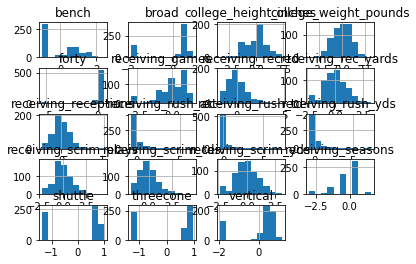

In [18]:
# histograms for some interesting measurements
X_train.hist()
pyplot.show()

In [19]:
result_df = test_df[['full_name', prediction_feature, 'position_group_rank']].copy()
print(result_df)
def result_df_viz(df, predictions, model_name):
    
    df[model_name] = predictions
    #return result_df.sort_values(by=['max_madden_pred'], ascending=False)
    return df

                   full_name  madden_cat  position_group_rank
fms_id                                                       
4866           Tyler Lockett          80                 10.0
576         Breshad Perriman          70                  5.0
166             Amari Cooper          80                  1.0
4690             Titus Davis          60                 39.0
1154         DaVaris Daniels          60                 29.0
1489               Deon Long          60                 32.0
3902         Phillip Dorsett          70                  6.0
1919            Geremy Davis          60                 23.0
2239         Jamison Crowder          80                 15.0
1422          DeVante Parker          80                  3.0
2895          Keith Mumphery          60                 37.0
1645    Dorial Green-Beckham          70                  8.0
697               Cam Worthy          40                 27.0
3035             Kevin White          70                  2.0
4462    

In [35]:
# Plot feature importance
def plot_feat_import(coef, model_title):
    feature_coef = pd.Series(index=X_train.columns, data=coef)
    print('{} model picked {} out of {} features'.format(model_title, str(sum(feature_coef != 0)), str(X_train.shape[1])))
    top_bottom_10 = pd.concat([feature_coef.sort_values().head(10), feature_coef.sort_values().tail(10)])
    top_bottom_10.plot(kind='barh', title='Feature importance (Top and bottom 10) - {} model'.format(model_title))
    #from W207 project (Fleishman, Hilton, Niu)
    
# Plot predictions
def plot_it(y_train, y_valid, model_title):
    plt.scatter(y_train, train_labels, c = "blue", alpha=0.6, marker = "o", label = "Training data")
    plt.scatter(y_valid, dev_labels, c = "green", alpha=0.6, marker = "o", label = "Validation data")
    plt.title(model_title)
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    plt.show()
    
def print_results(true_val, predict_val):
    print('Accuracy:  ' + str(accuracy_score(true_val, predict_val)))
    print('R2 : ' + str(r2_score(true_val, predict_val)))
    print('MSE : ' + str(mean_squared_error(true_val, predict_val)))
    

def plot_confusion(mat, model):
    
    array = mat
    df_cm = pd.DataFrame(array, index = [i for i in class_names],
                      columns = [i for i in class_names])
    plt.figure(figsize = (10,7))
    plt.title(model)
    sn.heatmap(df_cm, annot=True, cmap="Blues")


#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    
    
class_names = [40, 50, 60, 70, 80, 90]

In [ ]:
#functions for models


Accuracy:  0.42105263157894735
R2 : -1.7636363636363632
MSE : 284.2105263157895


,full_name,madden_cat,position_group_rank,Log_Regression,AdaBoost
fms_id,,,,,
4866,Tyler Lockett,80,10.0,40,70.0
576,Breshad Perriman,70,5.0,40,70.0
166,Amari Cooper,80,1.0,70,80.0
4690,Titus Davis,60,39.0,70,70.0
1154,DaVaris Daniels,60,29.0,70,60.0
1489,Deon Long,60,32.0,40,60.0
3902,Phillip Dorsett,70,6.0,70,70.0
1919,Geremy Davis,60,23.0,60,60.0
2239,Jamison Crowder,80,15.0,70,60.0


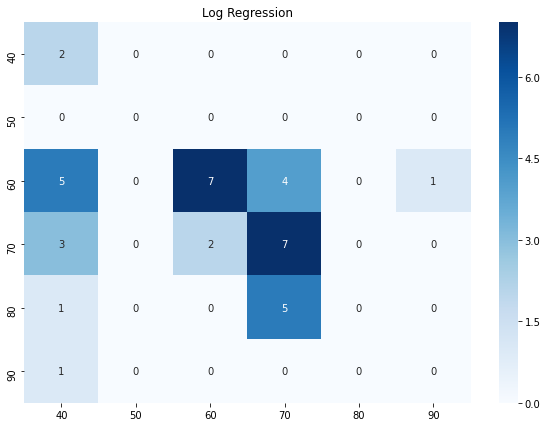

In [38]:
#Logistic Regression:
clf = LogisticRegression(random_state=1).fit(X_train, Y_train)
madden_predict = clf.predict(X_validation)
print_results(Y_validation, madden_predict)
mat = confusion_matrix(Y_validation, madden_predict, labels = class_names)
plot_confusion(mat, 'Log Regression')
result_df_viz(result_df, madden_predict, 'Log_Regression')


Accuracy:  0.07894736842105263
R2 : -0.07423569023568999
MSE : 110.47368421052632
Lasso model picked 15 out of 19 features
----------


,full_name,madden_cat,position_group_rank,Log_Regression,AdaBoost,Lasso
fms_id,,,,,,
4866,Tyler Lockett,80,10.0,40,70.0,59.0
576,Breshad Perriman,70,5.0,40,70.0,61.0
166,Amari Cooper,80,1.0,70,80.0,65.0
4690,Titus Davis,60,39.0,70,70.0,63.0
1154,DaVaris Daniels,60,29.0,70,60.0,61.0
1489,Deon Long,60,32.0,40,60.0,54.0
3902,Phillip Dorsett,70,6.0,70,70.0,57.0
1919,Geremy Davis,60,23.0,60,60.0,59.0
2239,Jamison Crowder,80,15.0,70,60.0,61.0


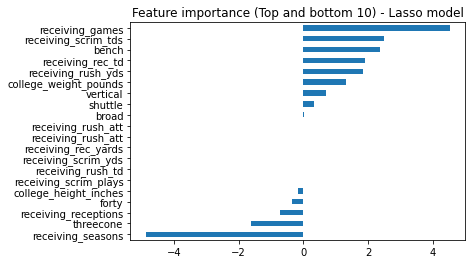

In [39]:
#Lasso:
alpha = 0.1
lasso_model = Lasso(alpha=alpha).fit(X_train, Y_train)
madden_predict = lasso_model.predict(X_validation)

madden_predict = np.around(madden_predict, decimals = 0)
print_results(Y_validation, madden_predict)
plot_feat_import(lasso_model.coef_, 'Lasso')  
#plot_it()
print('----------')
result_df_viz(result_df, madden_predict, 'Lasso')


Accuracy:  0.07894736842105263
R2 : -0.07218855218855191
MSE : 110.26315789473684
LassoCV Model
Lassocv model picked 13 out of 19 features
----------


,full_name,madden_cat,position_group_rank,Log_Regression,AdaBoost,Lasso,LassoCV
fms_id,,,,,,,
4866,Tyler Lockett,80,10.0,40,70.0,59.0,59.0
576,Breshad Perriman,70,5.0,40,70.0,61.0,61.0
166,Amari Cooper,80,1.0,70,80.0,65.0,65.0
4690,Titus Davis,60,39.0,70,70.0,63.0,63.0
1154,DaVaris Daniels,60,29.0,70,60.0,61.0,61.0
1489,Deon Long,60,32.0,40,60.0,54.0,54.0
3902,Phillip Dorsett,70,6.0,70,70.0,57.0,57.0
1919,Geremy Davis,60,23.0,60,60.0,59.0,59.0
2239,Jamison Crowder,80,15.0,70,60.0,61.0,61.0


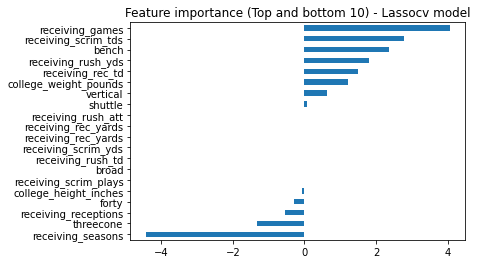

In [40]:
#Lassocv:

lasso_modelcv = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
madden_predict = lasso_modelcv.predict(X_validation)
madden_predict = np.around(madden_predict, decimals = 0)
print_results(Y_validation, madden_predict)
print('LassoCV Model')
plot_feat_import(lasso_modelcv.coef_, 'Lassocv') 
print('----------')
result_df_viz(result_df, madden_predict, 'LassoCV')


Accuracy:  0.05263157894736842
R2 : -0.05555555555555536
MSE : 108.55263157894737
RidgeCV model picked 19 out of 19 features
----------


,full_name,madden_cat,position_group_rank,Log_Regression,AdaBoost,Lasso,LassoCV,RidgeCV
fms_id,,,,,,,,
4866,Tyler Lockett,80,10.0,40,70.0,59.0,59.0,60.0
576,Breshad Perriman,70,5.0,40,70.0,61.0,61.0,63.0
166,Amari Cooper,80,1.0,70,80.0,65.0,65.0,65.0
4690,Titus Davis,60,39.0,70,70.0,63.0,63.0,63.0
1154,DaVaris Daniels,60,29.0,70,60.0,61.0,61.0,61.0
1489,Deon Long,60,32.0,40,60.0,54.0,54.0,54.0
3902,Phillip Dorsett,70,6.0,70,70.0,57.0,57.0,58.0
1919,Geremy Davis,60,23.0,60,60.0,59.0,59.0,59.0
2239,Jamison Crowder,80,15.0,70,60.0,61.0,61.0,61.0


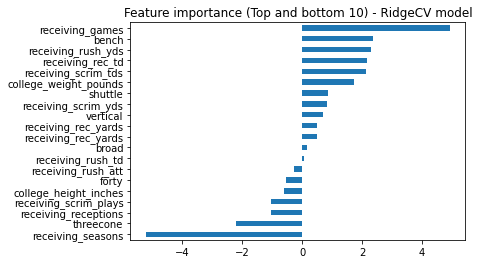

In [43]:
#RidgeCV:

ridge_model = RidgeCV(cv=5).fit(X_train, Y_train)
madden_predict = ridge_model.predict(X_validation)
madden_predict = np.around(madden_predict, decimals = 0)
print_results(Y_validation, madden_predict)

plot_feat_import(ridge_model.coef_, 'RidgeCV')
print('----------')
result_df_viz(result_df, madden_predict, 'RidgeCV')

Accuracy:  0.13157894736842105
R2 : -0.06604713804713791
MSE : 109.63157894736842
ElasticNetCV model picked 18 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,AdaBoost,Lasso,LassoCV,RidgeCV,ElasticNetCV
fms_id,,,,,,,,,
4866,Tyler Lockett,80,10.0,40,70.0,59.0,59.0,60.0,60.0
576,Breshad Perriman,70,5.0,40,70.0,61.0,61.0,63.0,61.0
166,Amari Cooper,80,1.0,70,80.0,65.0,65.0,65.0,65.0
4690,Titus Davis,60,39.0,70,70.0,63.0,63.0,63.0,63.0
1154,DaVaris Daniels,60,29.0,70,60.0,61.0,61.0,61.0,61.0
1489,Deon Long,60,32.0,40,60.0,54.0,54.0,54.0,55.0
3902,Phillip Dorsett,70,6.0,70,70.0,57.0,57.0,58.0,58.0
1919,Geremy Davis,60,23.0,60,60.0,59.0,59.0,59.0,59.0
2239,Jamison Crowder,80,15.0,70,60.0,61.0,61.0,61.0,60.0


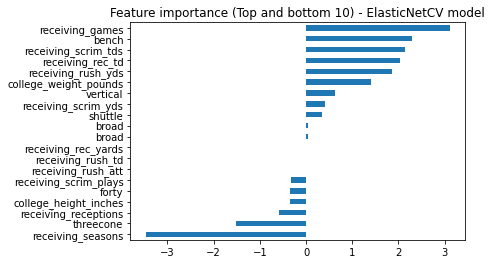

In [44]:
#ElasticNetCV:

elasticnetcv_model = ElasticNetCV(cv=5, random_state=0).fit(X_train, Y_train)
madden_predict = elasticnetcv_model.predict(X_validation)
madden_predict = np.around(madden_predict, decimals = 0)
print_results(Y_validation, madden_predict)
plot_feat_import(elasticnetcv_model.coef_, 'ElasticNetCV')
result_df_viz(result_df, madden_predict, 'ElasticNetCV')

Accuracy:  0.23684210526315788
R2 : -1.2774410774410772
MSE : 234.21052631578948
Decision Tree Regressor model picked 19 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,AdaBoost,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg
fms_id,,,,,,,,,,
4866,Tyler Lockett,80,10.0,40,70.0,59.0,59.0,60.0,60.0,80.0
576,Breshad Perriman,70,5.0,40,70.0,61.0,61.0,63.0,61.0,70.0
166,Amari Cooper,80,1.0,70,80.0,65.0,65.0,65.0,65.0,80.0
4690,Titus Davis,60,39.0,70,70.0,63.0,63.0,63.0,63.0,40.0
1154,DaVaris Daniels,60,29.0,70,60.0,61.0,61.0,61.0,61.0,40.0
1489,Deon Long,60,32.0,40,60.0,54.0,54.0,54.0,55.0,70.0
3902,Phillip Dorsett,70,6.0,70,70.0,57.0,57.0,58.0,58.0,60.0
1919,Geremy Davis,60,23.0,60,60.0,59.0,59.0,59.0,59.0,60.0
2239,Jamison Crowder,80,15.0,70,60.0,61.0,61.0,61.0,60.0,60.0


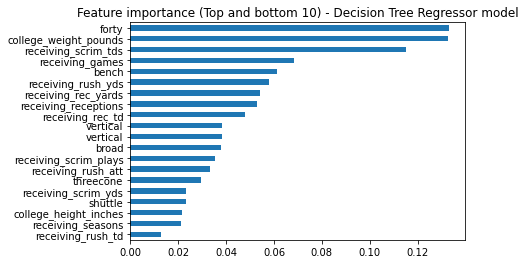

In [46]:
#Decision Tree Regressor
from sklearn import tree
decisiontreeregrssor = DecisionTreeRegressor()
decisiontreeregrssor.fit(X_train, Y_train)
madden_predict = decisiontreeregrssor.predict(X_validation)
print_results(Y_validation, madden_predict)
plot_feat_import(decisiontreeregrssor.feature_importances_, 'Decision Tree Regressor')
result_df_viz(result_df, madden_predict, 'Decision_Tree_Reg')

Accuracy:  0.5526315789473685
R2 : -0.02356902356902335
MSE : 105.26315789473684
AdaBoostRegressor model picked 19 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,AdaBoost,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg
fms_id,,,,,,,,,,
4866,Tyler Lockett,80,10.0,40,70.0,59.0,59.0,60.0,60.0,80.0
576,Breshad Perriman,70,5.0,40,70.0,61.0,61.0,63.0,61.0,70.0
166,Amari Cooper,80,1.0,70,80.0,65.0,65.0,65.0,65.0,80.0
4690,Titus Davis,60,39.0,70,70.0,63.0,63.0,63.0,63.0,40.0
1154,DaVaris Daniels,60,29.0,70,60.0,61.0,61.0,61.0,61.0,40.0
1489,Deon Long,60,32.0,40,60.0,54.0,54.0,54.0,55.0,70.0
3902,Phillip Dorsett,70,6.0,70,70.0,57.0,57.0,58.0,58.0,60.0
1919,Geremy Davis,60,23.0,60,60.0,59.0,59.0,59.0,59.0,60.0
2239,Jamison Crowder,80,15.0,70,60.0,61.0,61.0,61.0,60.0,60.0


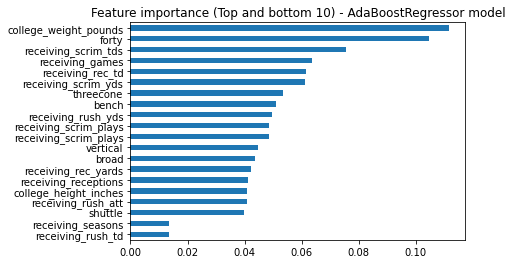

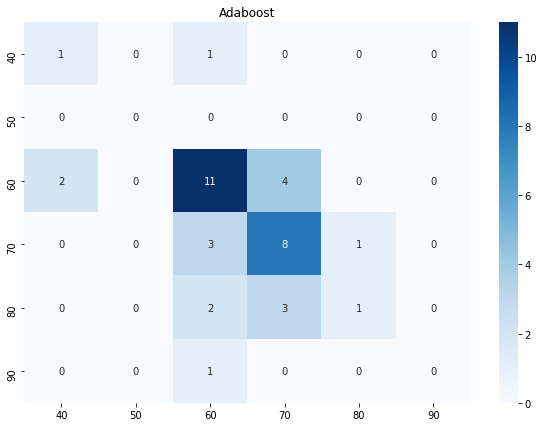

In [48]:
#Adaboost
adaboostregressor = AdaBoostRegressor(DecisionTreeRegressor(criterion='mse'), n_estimators=100, loss='linear', learning_rate=1, random_state=1)
adaboostregressor.fit(X_train, Y_train)
madden_predict = adaboostregressor.predict(X_validation)
print_results(Y_validation, madden_predict)
plot_feat_import(adaboostregressor.feature_importances_, 'AdaBoostRegressor')
mat = confusion_matrix(Y_validation, madden_predict, labels = class_names)
plot_confusion(mat, 'Adaboost')
result_df_viz(result_df, madden_predict, 'AdaBoost')
#plot_confusion_matrix(adaboostregressor, X_validation, Y_validation)


Accuracy:  0.23684210526315788
R2 : -2.019528619528619
MSE : 310.5263157894737
Decision Tree Classifier model picked 19 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,AdaBoost,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,Decision_Tree_Class
fms_id,,,,,,,,,,,
4866,Tyler Lockett,80,10.0,40,70.0,59.0,59.0,60.0,60.0,80.0,60
576,Breshad Perriman,70,5.0,40,70.0,61.0,61.0,63.0,61.0,70.0,60
166,Amari Cooper,80,1.0,70,80.0,65.0,65.0,65.0,65.0,80.0,80
4690,Titus Davis,60,39.0,70,70.0,63.0,63.0,63.0,63.0,40.0,40
1154,DaVaris Daniels,60,29.0,70,60.0,61.0,61.0,61.0,61.0,40.0,70
1489,Deon Long,60,32.0,40,60.0,54.0,54.0,54.0,55.0,70.0,40
3902,Phillip Dorsett,70,6.0,70,70.0,57.0,57.0,58.0,58.0,60.0,40
1919,Geremy Davis,60,23.0,60,60.0,59.0,59.0,59.0,59.0,60.0,40
2239,Jamison Crowder,80,15.0,70,60.0,61.0,61.0,61.0,60.0,60.0,60


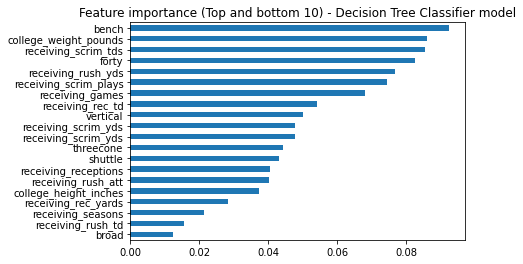

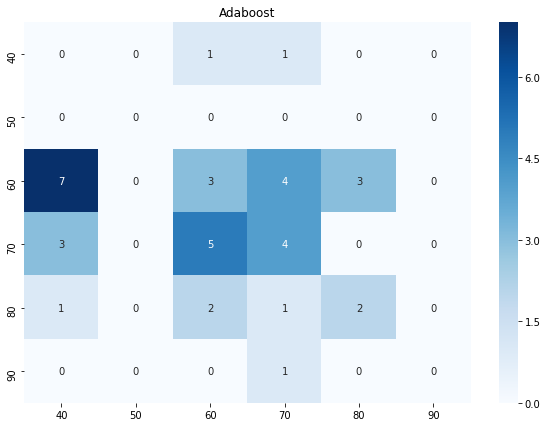

In [53]:
#Decision Tree
from sklearn import tree
decisiontree = DecisionTreeClassifier(max_depth = 100)
decisiontree.fit(X_train, Y_train)
madden_predict = decisiontree.predict(X_validation)
print_results(Y_validation, madden_predict)
plot_feat_import(decisiontree.feature_importances_, 'Decision Tree Classifier')
mat = confusion_matrix(Y_validation, madden_predict, labels = class_names)
plot_confusion(mat, 'Adaboost')
result_df_viz(result_df, madden_predict, 'Decision_Tree_Class')

Accuracy:  0.39473684210526316
R2 : -2.019528619528619
MSE : 310.5263157894737
Extra Tree Classifier model picked 19 out of 19 features


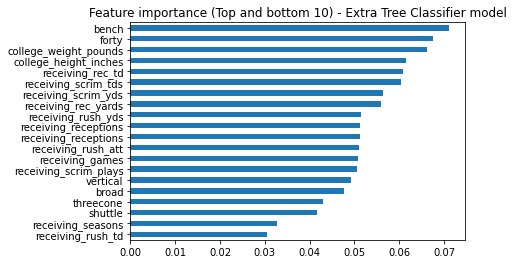

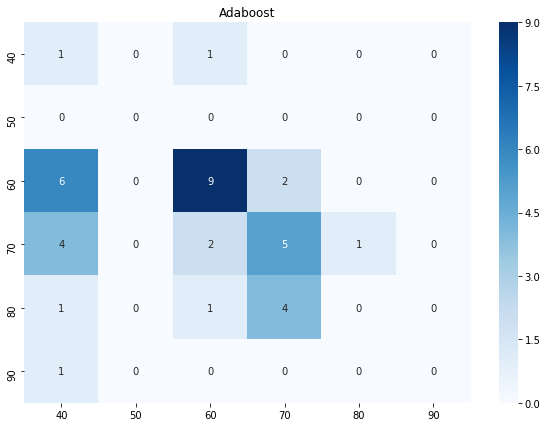

In [55]:
#Extra Tree


from sklearn import tree
extradecisiontree = ExtraTreesClassifier(max_depth = 300)
extradecisiontree.fit(X_train, Y_train)
madden_predict = extradecisiontree.predict(X_validation)
print_results(Y_validation, madden_predict)
plot_feat_import(extradecisiontree.feature_importances_, 'Extra Tree Classifier')
result_df_viz(result_df, madden_predict, 'Extra_Tree')
mat = confusion_matrix(Y_validation, madden_predict, labels = class_names)
plot_confusion(mat, 'Adaboost')

Accuracy:  0.23684210526315788
R2 : -2.1218855218855213
MSE : 321.05263157894734
AdaBoostClassifier model picked 19 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,AdaBoost,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,Decision_Tree_Class,Extra_Tree,AdaBoost_Class
fms_id,,,,,,,,,,,,,
4866,Tyler Lockett,80,10.0,40,70.0,59.0,59.0,60.0,60.0,80.0,60,40,40
576,Breshad Perriman,70,5.0,40,70.0,61.0,61.0,63.0,61.0,70.0,60,60,60
166,Amari Cooper,80,1.0,70,80.0,65.0,65.0,65.0,65.0,80.0,80,70,80
4690,Titus Davis,60,39.0,70,70.0,63.0,63.0,63.0,63.0,40.0,40,40,40
1154,DaVaris Daniels,60,29.0,70,60.0,61.0,61.0,61.0,61.0,40.0,70,60,70
1489,Deon Long,60,32.0,40,60.0,54.0,54.0,54.0,55.0,70.0,40,40,40
3902,Phillip Dorsett,70,6.0,70,70.0,57.0,57.0,58.0,58.0,60.0,40,70,80
1919,Geremy Davis,60,23.0,60,60.0,59.0,59.0,59.0,59.0,60.0,40,60,40
2239,Jamison Crowder,80,15.0,70,60.0,61.0,61.0,61.0,60.0,60.0,60,70,60


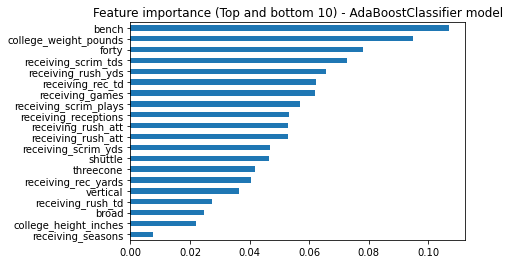

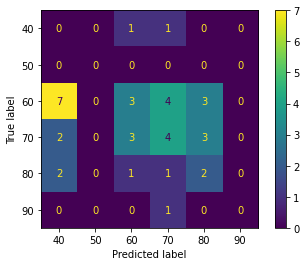

In [58]:
#Adaboost
adaboostclassifier = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=500)
adaboostclassifier.fit(X_train, Y_train)
madden_predict = adaboostclassifier.predict(X_validation)
print_results(Y_validation, madden_predict)
plot_feat_import(adaboostclassifier.feature_importances_, 'AdaBoostClassifier')

plot_confusion_matrix(adaboostclassifier, X_validation, Y_validation, labels = class_names)
result_df_viz(result_df, madden_predict, 'AdaBoost_Class')


Accuracy:  0.39473684210526316
R2 : -2.403367003367003
MSE : 350.0


,full_name,madden_cat,position_group_rank,Log_Regression,AdaBoost,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,Decision_Tree_Class,Extra_Tree,AdaBoost_Class,SVM
fms_id,,,,,,,,,,,,,,
4866,Tyler Lockett,80,10.0,40,70.0,59.0,59.0,60.0,60.0,80.0,60,40,40,40
576,Breshad Perriman,70,5.0,40,70.0,61.0,61.0,63.0,61.0,70.0,60,60,60,70
166,Amari Cooper,80,1.0,70,80.0,65.0,65.0,65.0,65.0,80.0,80,70,80,40
4690,Titus Davis,60,39.0,70,70.0,63.0,63.0,63.0,63.0,40.0,40,40,40,40
1154,DaVaris Daniels,60,29.0,70,60.0,61.0,61.0,61.0,61.0,40.0,70,60,70,60
1489,Deon Long,60,32.0,40,60.0,54.0,54.0,54.0,55.0,70.0,40,40,40,60
3902,Phillip Dorsett,70,6.0,70,70.0,57.0,57.0,58.0,58.0,60.0,40,70,80,70
1919,Geremy Davis,60,23.0,60,60.0,59.0,59.0,59.0,59.0,60.0,40,60,40,60
2239,Jamison Crowder,80,15.0,70,60.0,61.0,61.0,61.0,60.0,60.0,60,70,60,70


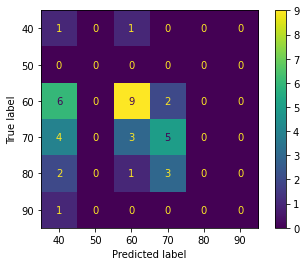

In [60]:
#SVM
svmclassifier = SVC(gamma='auto')
svmclassifier.fit(X_train, Y_train)
madden_predict = svmclassifier.predict(X_validation)
print_results(Y_validation, madden_predict)
#plot_feat_import(svmclassifier.feature_importances_, 'SVC')
plot_confusion_matrix(svmclassifier, X_validation, Y_validation, labels = class_names)
result_df_viz(result_df, madden_predict, 'SVM')

Accuracy:  0.4473684210526316
R2 : -1.4053872053872052
MSE : 247.3684210526316
Random Forest model picked 19 out of 19 features


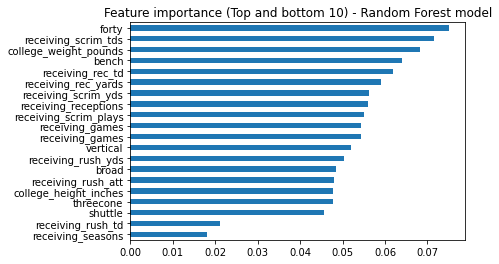

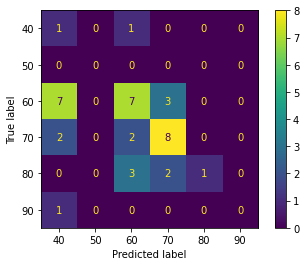

In [61]:
#RandomForest
rfclassifier = RandomForestClassifier()
rfclassifier.fit(X_train, Y_train)
madden_predict = rfclassifier.predict(X_validation)
print_results(Y_validation, madden_predict)
plot_feat_import(rfclassifier.feature_importances_, 'Random Forest')
result_df_viz(result_df, madden_predict, 'RF_Class')
plot_confusion_matrix(rfclassifier, X_validation, Y_validation, labels = class_names)

In [83]:
#PCA with Linear Regression
pca = PCA(n_components=5)
pca_x = pca.fit_transform(X_train)
pca_validation = pca.transform(X_validation)

log_pca = LogisticRegression(random_state=0).fit(pca_x, Y_train)
madden_predict = log_pca.predict(pca_validation)
print_results(Y_validation, madden_predict)
#print(log_pca.coef_.shape)
#plot_feat_import(log_pca.coef_, 'PCA with Log Regression')
result_df_viz(result_df, madden_predict, 'Log_PCA')

Accuracy:  0.2631578947368421
R2 : -2.1218855218855213
MSE : 321.05263157894734


,full_name,madden_cat,position_group_rank,Log_Regression,AdaBoost,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,Decision_Tree_Class,Extra_Tree,AdaBoost_Class,SVM,RF_Class,Log_PCA
fms_id,,,,,,,,,,,,,,,,
4866,Tyler Lockett,80,10.0,40,70.0,59.0,59.0,60.0,60.0,80.0,60,40,40,40,70,70
576,Breshad Perriman,70,5.0,40,70.0,61.0,61.0,63.0,61.0,70.0,60,60,60,70,70,40
166,Amari Cooper,80,1.0,70,80.0,65.0,65.0,65.0,65.0,80.0,80,70,80,40,80,70
4690,Titus Davis,60,39.0,70,70.0,63.0,63.0,63.0,63.0,40.0,40,40,40,40,40,70
1154,DaVaris Daniels,60,29.0,70,60.0,61.0,61.0,61.0,61.0,40.0,70,60,70,60,60,40
1489,Deon Long,60,32.0,40,60.0,54.0,54.0,54.0,55.0,70.0,40,40,40,60,40,40
3902,Phillip Dorsett,70,6.0,70,70.0,57.0,57.0,58.0,58.0,60.0,40,70,80,70,70,40
1919,Geremy Davis,60,23.0,60,60.0,59.0,59.0,59.0,59.0,60.0,40,60,40,60,60,60
2239,Jamison Crowder,80,15.0,70,60.0,61.0,61.0,61.0,60.0,60.0,60,70,60,70,60,70


Accuracy:  0.02631578947368421
R2 : 0.019164983164983274
MSE : 100.86842105263158
Gradient Booster Regressor model picked 19 out of 19 features


,full_name,madden_cat,position_group_rank,Log_Regression,AdaBoost,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,Decision_Tree_Class,Extra_Tree,AdaBoost_Class,SVM,RF_Class,Log_PCA,GB_Regressor
fms_id,,,,,,,,,,,,,,,,,
4866,Tyler Lockett,80,10.0,40,70.0,59.0,59.0,60.0,60.0,80.0,60,40,40,40,70,70,68.0
576,Breshad Perriman,70,5.0,40,70.0,61.0,61.0,63.0,61.0,70.0,60,60,60,70,70,40,67.0
166,Amari Cooper,80,1.0,70,80.0,65.0,65.0,65.0,65.0,80.0,80,70,80,40,80,70,79.0
4690,Titus Davis,60,39.0,70,70.0,63.0,63.0,63.0,63.0,40.0,40,40,40,40,40,70,63.0
1154,DaVaris Daniels,60,29.0,70,60.0,61.0,61.0,61.0,61.0,40.0,70,60,70,60,60,40,50.0
1489,Deon Long,60,32.0,40,60.0,54.0,54.0,54.0,55.0,70.0,40,40,40,60,40,40,54.0
3902,Phillip Dorsett,70,6.0,70,70.0,57.0,57.0,58.0,58.0,60.0,40,70,80,70,70,40,66.0
1919,Geremy Davis,60,23.0,60,60.0,59.0,59.0,59.0,59.0,60.0,40,60,40,60,60,60,54.0
2239,Jamison Crowder,80,15.0,70,60.0,61.0,61.0,61.0,60.0,60.0,60,70,60,70,60,70,55.0


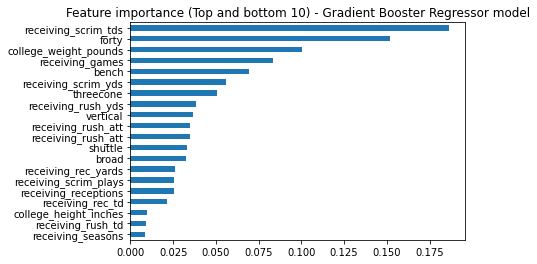

In [84]:
#Gradient Booster Regressor
import numpy as np
gradientboostingregressor = GradientBoostingRegressor(random_state=0)
gradientboostingregressor.fit(X_train, Y_train)
madden_predict = gradientboostingregressor.predict(X_validation)
madden_predict = np.around(madden_predict, decimals = 0)
print_results(Y_validation, madden_predict)
plot_feat_import(gradientboostingregressor.feature_importances_, 'Gradient Booster Regressor')
result_df_viz(result_df, madden_predict, 'GB_Regressor')

In [85]:
from scipy.stats import rankdata
print(result_df.columns[3:])
rank_df = result_df[result_df.columns[3:]]
#for col in rank_df.columns:
#    rank_df[col] = rankdata(rank_df[col].values)

Index(['Log_Regression', 'AdaBoost', 'Lasso', 'LassoCV', 'RidgeCV',
       'ElasticNetCV', 'Decision_Tree_Reg', 'Decision_Tree_Class',
       'Extra_Tree', 'AdaBoost_Class', 'SVM', 'RF_Class', 'Log_PCA',
       'GB_Regressor'],
      dtype='object')


In [86]:
def rank(row):
    print()
    return row.sum()/len(row)
result_df['rank'] = rank_df.apply(rank, axis=1)
result_df

,full_name,madden_cat,position_group_rank,Log_Regression,AdaBoost,Lasso,LassoCV,RidgeCV,ElasticNetCV,Decision_Tree_Reg,Decision_Tree_Class,Extra_Tree,AdaBoost_Class,SVM,RF_Class,Log_PCA,GB_Regressor,rank
fms_id,,,,,,,,,,,,,,,,,,
4866,Tyler Lockett,80,10.0,40,70.0,59.0,59.0,60.0,60.0,80.0,60,40,40,40,70,70,68.0,58.285714
576,Breshad Perriman,70,5.0,40,70.0,61.0,61.0,63.0,61.0,70.0,60,60,60,70,70,40,67.0,60.928571
166,Amari Cooper,80,1.0,70,80.0,65.0,65.0,65.0,65.0,80.0,80,70,80,40,80,70,79.0,70.642857
4690,Titus Davis,60,39.0,70,70.0,63.0,63.0,63.0,63.0,40.0,40,40,40,40,40,70,63.0,54.642857
1154,DaVaris Daniels,60,29.0,70,60.0,61.0,61.0,61.0,61.0,40.0,70,60,70,60,60,40,50.0,58.857143
1489,Deon Long,60,32.0,40,60.0,54.0,54.0,54.0,55.0,70.0,40,40,40,60,40,40,54.0,50.071429
3902,Phillip Dorsett,70,6.0,70,70.0,57.0,57.0,58.0,58.0,60.0,40,70,80,70,70,40,66.0,61.857143
1919,Geremy Davis,60,23.0,60,60.0,59.0,59.0,59.0,59.0,60.0,40,60,40,60,60,60,54.0,56.428571
2239,Jamison Crowder,80,15.0,70,60.0,61.0,61.0,61.0,60.0,60.0,60,70,60,70,60,70,55.0,62.714286


In [87]:
#def rank(row):
#    print()
#    return row.sum()/len(row)
#result_df['rank'] = rankdata(rank_df.apply(rank, axis=1))

ordered_df = result_df[['full_name', 'AdaBoost', prediction_feature, 'position_group_rank']].sort_values(by=['AdaBoost'], ascending=False)
ordered_df

,full_name,AdaBoost,madden_cat,position_group_rank
fms_id,,,,
166,Amari Cooper,80.0,80,1.0
2117,Jaelen Strong,80.0,70,11.0
4866,Tyler Lockett,70.0,80,10.0
3035,Kevin White,70.0,70,2.0
3741,Nelson Agholor,70.0,80,4.0
2787,Justin Hardy,70.0,70,16.0
4286,Sammie Coates,70.0,70,13.0
1397,DeAndre Smelter,70.0,60,30.0
1150,Da'Ron Brown,70.0,60,28.0


In [ ]:
ordered_df.to_csv('rank_of_picks.csv')

eclf = VotingClassifier(estimators=[('svc', svmclassifier), ('extratrees', extradecisiontree), ('rf', rfclassifier), ('logpca', log_pca)],voting='hard')


for clf, label in zip([svmclassifier, extradecisiontree, rfclassifier, log_pca, eclf], ['SVC', 'Extra Trees', 'Random Forest', 'Log_pca', 'Ensemble']): 
    scores = cross_val_score(clf, value_data, label_data, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
#



In [57]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
#models.append(('LASSO', Lasso(alpha=0.1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('GBC', GradientBoostingClassifier(n_estimators=200)))
models.append(('RFC', RandomForestClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('ETC', ExtraTreesClassifier()))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


C:\Users\jonat\Anaconda3\envs\tf-gpu2.0\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\jonat\Anaconda3\envs\tf-gpu2.0\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


LR: 0.419227 (0.040362)
LDA: 0.411239 (0.051698)
KNN: 0.371249 (0.026024)


C:\Users\jonat\Anaconda3\envs\tf-gpu2.0\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\jonat\Anaconda3\envs\tf-gpu2.0\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


CART: 0.305556 (0.051366)


C:\Users\jonat\Anaconda3\envs\tf-gpu2.0\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


ABC: 0.279852 (0.059422)


C:\Users\jonat\Anaconda3\envs\tf-gpu2.0\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


GBC: 0.409626 (0.029059)


C:\Users\jonat\Anaconda3\envs\tf-gpu2.0\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


RFC: 0.436790 (0.040151)
GNB: 0.302279 (0.055628)


C:\Users\jonat\Anaconda3\envs\tf-gpu2.0\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\jonat\Anaconda3\envs\tf-gpu2.0\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


SVM: 0.406272 (0.035698)


C:\Users\jonat\Anaconda3\envs\tf-gpu2.0\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


ETC: 0.415822 (0.054020)


In [ ]:
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()